In [17]:
from copy import deepcopy

import numpy as np
import sympy
from matplotlib import pyplot as plt

from chemistry_data.chem_tools import prepare_hamiltonian_refstates, real_time_propagator
from filter_state.utils_plot import plot_state_histogram
from filter_state.utils_quantum import initialize_reference_state, collect_degeneracy
from ofex.classical_algorithms.filter_functions import gaussian_function_fourier
from ofex.classical_algorithms.funcapprox import plot_functions
from ofex.linalg.sparse_tools import apply_operator
from ofex.state.state_tools import normalize



In [18]:
mol_name = "H4"

data = prepare_hamiltonian_refstates(mol_name=mol_name, transform="symmetry_conserving_bravyi_kitaev",
                                     print_progress=True)
pham, norm, ref_state, eigval_overlap_pair = initialize_reference_state(**data, print_progress=True,
                                                                        initial_overlap='even')
transform, n_qubits, = data['transform'], data['n_qubits']

 === Start Preparing Hamiltonian ===
 === MolecularData Done (0.2407526969909668 sec) ===
 === Fermion Hamiltonian Loaded from ../chemistry_data/hamiltonian/H4/fermion.pkl ===
 === Qubit Hamiltonian Loaded from ../chemistry_data/hamiltonian/H4/symmetry_conserving_bravyi_kitaev.pkl ===
 === Hamiltonian Preparation Done (0.24291634559631348) ===
 === CISD state Loaded from ../chemistry_data/reference_state/H4/cisd_symmetry_conserving_bravyi_kitaev.pkl ===
 === Spectrum Analysis Loaded from ../chemistry_data/spectrum/H4/HF_symmetry_conserving_bravyi_kitaev.pkl ===


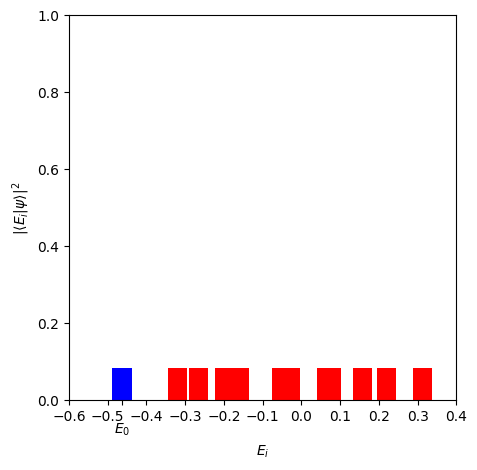

In [19]:
from chemistry_data.chem_tools import spectrum_analysis

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
degenerated = collect_degeneracy(eigval_overlap_pair)
plot_state_histogram(fig, ax, degenerated, min_gap=0.05)

plt.show()

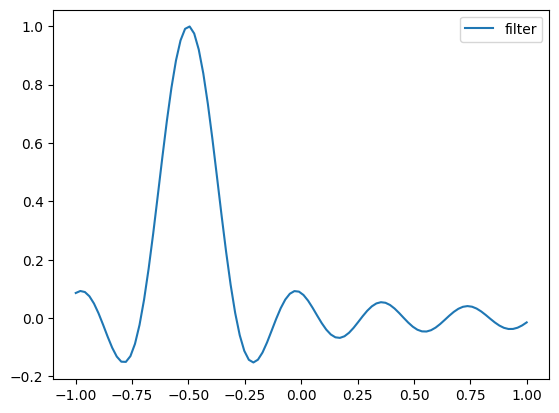

[<Axes: >]

In [20]:
target_fluc = 0.1
target_width = 0.06
target_center = -0.5
period = 4.0

# alpha = kaiser_find_alpha_from_fluct(target_fluc)
# n_fourier = kaiser_find_n(alpha, target_width, period)

# filter_func, filter_coeff, filter_freqs = kaiser_filter_fourier(n_fourier, alpha, target_center, period)
n_fourier = 10
filter_func, filter_coeff, filter_freqs = gaussian_function_fourier(n_fourier, target_width, target_center, period)

plot_functions({"filter": filter_func}, sympy.symbols("x"),)

In [21]:
time_step = 2.0 * np.pi / period
n_trotter = None

prop = real_time_propagator(mol_name, transform, pham, time_step, n_qubits, n_trotter, tag="normalized_1")
prop_now = deepcopy(prop)
filter_operator = np.eye(prop.shape[0], dtype=complex) * filter_coeff[n_fourier]
assert np.isclose(filter_freqs[n_fourier], 0.0)
for n in range(1, n_fourier + 1):
    assert np.isclose(filter_freqs[n_fourier + n], time_step * n)
    assert np.isclose(filter_freqs[n_fourier - n], -time_step * n)
    neg_coeff, pos_coeff = filter_coeff[n_fourier + n], filter_coeff[n_fourier - n]
    filter_operator += prop_now * neg_coeff
    filter_operator += prop_now.T.conj() * pos_coeff
    if n != n_fourier:
        prop_now = prop_now @ prop

filtered_state = normalize(apply_operator(filter_operator, ref_state))

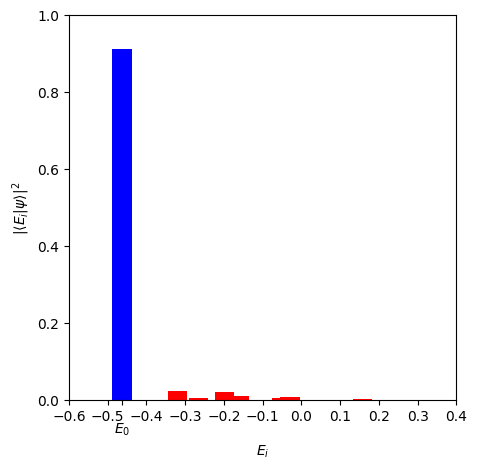

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

filtered_eigval_overlap_pair, eig_energies = spectrum_analysis(pham, filtered_state, mol_name, transform, ref_name="Filtered", save=False)
filtered_degenerated = collect_degeneracy(filtered_eigval_overlap_pair)
plot_state_histogram(fig, ax, filtered_degenerated, min_gap=0.05)

plt.show()

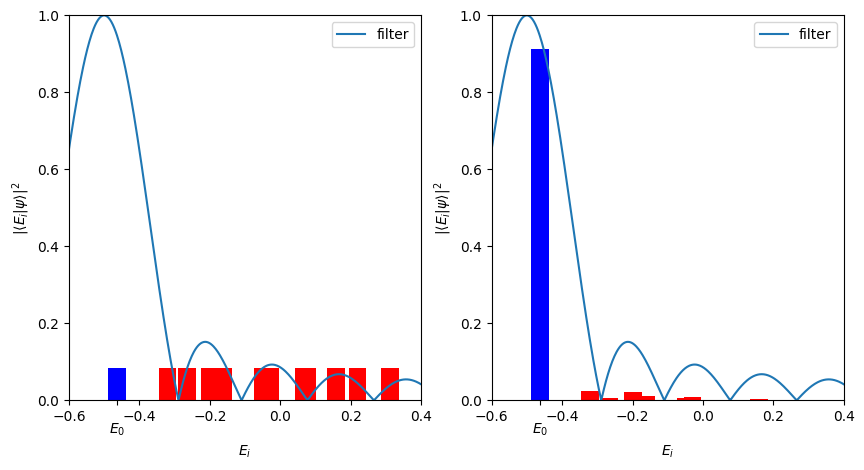

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_state_histogram(fig, ax[0], degenerated, min_gap=0.05)
plot_functions({"filter": sympy.Abs(filter_func)}, sympy.symbols("x"), x_points=np.linspace(-1, 1, 1000), axes=[ax[0]], plot=False)
plot_state_histogram(fig, ax[1], filtered_degenerated, min_gap=0.05)
plot_functions({"filter": sympy.Abs(filter_func)}, sympy.symbols("x"), x_points=np.linspace(-1, 1, 1000), axes=[ax[1]], plot=False)

plt.show()